<h1> Soft Actor Critic</h1>

Borrows liberally from the <a href="https://towardsdatascience.com/soft-actor-critic-demystified-b8427df61665">Towards Data Science implementation of Soft-Actor Critic,</a> which was itself adapted from <a href="https://github.com/higgsfield/RL-Adventure-2">higgsfield's implementation</a>. <a href="https://arxiv.org/pdf/1801.01290.pdf">The original paper is here.</a> Borrowed some ideas from <a href="https://medium.com/@kengz/soft-actor-critic-for-continuous-and-discrete-actions-eeff6f651954">this site, in particular with regards to the temperature scaling.</a> 

In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display

%matplotlib inline

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Auxilliary Functions</h2>

In [2]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [3]:
class NormalizedActions(gym.ActionWrapper):
    def _action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return actions

In [4]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

<h1>Network Definitions</h1>

In [5]:
# class ValueNetwork(nn.Module):
#     def __init__(self, state_dim, hidden_dim, init_w=3e-3):
#         super(ValueNetwork, self).__init__()
        
#         self.linear1 = nn.Linear(state_dim, hidden_dim)
#         self.linear2 = nn.Linear(hidden_dim, hidden_dim)
#         self.linear3 = nn.Linear(hidden_dim, 1)
        
#         self.linear3.weight.data.uniform_(-init_w, init_w)
#         self.linear3.bias.data.uniform_(-init_w, init_w)
        
#     def forward(self, state):
#         x = F.relu(self.linear1(state))
#         x = F.relu(self.linear2(x))
#         x = self.linear3(x)
#         return x
        
        
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample()
        action = torch.tanh(mean+ std*z.to(device))
        log_prob = Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample().to(device)
        action = torch.tanh(mean + std*z)
        
        action  = action.cpu()#.detach().cpu().numpy()
        return action[0]

    
# class TemperatureNetwork(nn.Module):
#     def __init__(self, hidden_dim, init_w=3e-3):
#         super(TemperatureNetwork, self).__init__()
        
#         self.linear1 = nn.Linear(1, hidden_dim)
#         self.linear2 = nn.Linear(hidden_dim, hidden_dim)
#         self.linear3 = nn.Linear(hidden_dim, 1)
        
#         self.linear3.weight.data.uniform_(-init_w, init_w)
#         self.linear3.bias.data.uniform_(-init_w, init_w)
        
#     def forward(self):
#         x = F.relu(self.linear1(torch.zeros(1)))
#         x = F.relu(self.linear2(x))
#         x = self.linear3(x)
#         return x

<h1> Update Function </h1>

In [6]:
def update(batch_size,gamma=0.99,soft_tau=1e-2,):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    new_action, log_prob, epsilon, mean, log_std = policy_net.evaluate(state)
    next_action = policy_net.get_action(next_state).detach()
    
    # predicted q values given the current state, current action, and current q functions
    predicted_q_value1 = soft_q_net1(state, action)
    predicted_q_value2 = soft_q_net2(state, action)
    #     predicted_value    = value_net(state)
#     predicted_q_value = torch.min(predicted_q_value1, predicted_q_value2)
    
    # predicted q values given the current state, new action, and current q functions
    predicted_new_q_value1 = soft_q_net1(state, new_action)
    predicted_new_q_value2 = soft_q_net2(state, new_action)
    predicted_new_q_value = torch.min(predicted_new_q_value1, predicted_new_q_value2)
    
    # predicted q values given the next state, next action, and TARGET q functions
    predicted_next_q_value1 = target_soft_q_net1(next_state, next_action)
    predicted_next_q_value2 = target_soft_q_net2(next_state, next_action)
    predicted_next_q_value = torch.min(predicted_next_q_value1, predicted_next_q_value2)
    
    # find the next value for the alpha
#     alpha = temperature_net()
    log_alpha = torch.zeros(1, requires_grad=True).to(device)
    alpha = log_alpha.detach().exp()
    
#     print(alpha)
#     print(next_action)
    
    
    
    
    # Training Q Function
#     target_value = (target_value_net(next_state))
#     target_q_value = reward + (1 - done) * gamma * target_value
    target_q_value = (reward + (1 - done) * gamma * (predicted_next_q_value - alpha*log_prob))
    q_value_loss1 = soft_q_criterion2(predicted_q_value1, target_q_value.detach())
    q_value_loss2 = soft_q_criterion2(predicted_q_value2, target_q_value.detach())

    soft_q_optimizer1.zero_grad()
    q_value_loss1.backward()
    soft_q_optimizer1.step()
    soft_q_optimizer2.zero_grad()
    q_value_loss2.backward()
    soft_q_optimizer2.step()  
    
#     # Training Value Function
#     predicted_new_q_value = torch.min(soft_q_net1(state, new_action),soft_q_net2(state, new_action))
#     target_value_func = predicted_new_q_value - log_prob
#     value_loss = value_criterion(predicted_value, target_value_func.detach())

    
#     value_optimizer.zero_grad()
#     value_loss.backward()
#     value_optimizer.step()
    
    
    # Training Policy Function
#     policy_loss = (log_prob - predicted_new_q_value.detach()).mean()
    policy_loss = (alpha*log_prob - predicted_new_q_value.detach()).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    # Update Target Network Weights
    for target_param, param in zip(target_soft_q_net1.parameters(), soft_q_net1.parameters()):
        target_param.data.copy_(
            param.data * soft_tau + target_param.data * (1.0 - soft_tau)
        )
    
    for target_param, param in zip(target_soft_q_net2.parameters(), soft_q_net2.parameters()):
        target_param.data.copy_(
            param.data * soft_tau + target_param.data * (1.0 - soft_tau)
        )
    
#     for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
#         target_param.data.copy_(
#             target_param.data * (1.0 - soft_tau) + param.data * soft_tau
#         )
    
    # Training Temperature Function
#     temperature_loss = (-alpha * (log_prob.detach() + action_dim)).mean()
    temperature_loss = -(log_alpha * (log_prob.detach() + target_entropy)).mean()
    
    temperature_optimizer.zero_grad()
    temperature_loss.backward()
    temperature_optimizer.step()

<h2> Initializations </h2>

In [7]:
env = NormalizedActions(gym.make("Pendulum-v0"))

action_dim = env.action_space.shape[0]
state_dim  = env.observation_space.shape[0]
hidden_dim = 256

# value_net        = ValueNetwork(state_dim, hidden_dim).to(device)
# target_value_net = ValueNetwork(state_dim, hidden_dim).to(device)

# initialize q approximator
soft_q_net1        = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
soft_q_net2        = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
target_soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
target_soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_soft_q_net1.parameters(), soft_q_net1.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_soft_q_net2.parameters(), soft_q_net1.parameters()):
    target_param.data.copy_(param.data)

# initialize policy approximator
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

# initialize temperature approximator
# temperature_net = TemperatureNetwork(hidden_dim).to(device)
log_alpha = torch.zeros(1, requires_grad=True).to(device)
alpha = log_alpha.detach().exp()
target_entropy = - np.product(env.action_space.shape)

# for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
#     target_param.data.copy_(param.data)
    

# value_criterion  = nn.MSELoss()
soft_q_criterion1 = nn.MSELoss()
soft_q_criterion2 = nn.MSELoss()

# value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4
temperature_lr  = 3e-4

# value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer1 = optim.Adam(soft_q_net1.parameters(), lr=soft_q_lr)
soft_q_optimizer2 = optim.Adam(soft_q_net2.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
temperature_optimizer  = optim.Adam([log_alpha], lr=temperature_lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

# Training Hyperparameters

In [8]:
max_frames  = 40000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128

# Training Loop

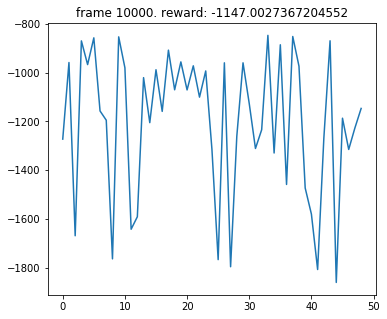

KeyboardInterrupt: 

In [9]:
while frame_idx < max_frames: # for one episode. TODO: fix for multiple episodes.
    state = env.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        if frame_idx >1000: # we have a decent policy going. switch from random exploration to on-policy.
            action = policy_net.get_action(state).detach()
            next_state, reward, done, _ = env.step(action.numpy())
        else: # not enough information to have good policies yet, so just pick randomly
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
        
        # add observation to the replay buffer
        replay_buffer.push(state, action, reward, next_state, done)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if len(replay_buffer) > batch_size:
            update(batch_size) # for each step, samples a batch out of the replay buffer to backprop through networks
        
        if frame_idx % 1000 == 0:
            plot(frame_idx, rewards)
        
        if done:
            break
        
    rewards.append(episode_reward)